In [177]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from collections import Counter

Clima/Queda


In [178]:
df1 = pd.read_csv('clima_queda_parelheiros_2019-2023.csv')
df2 = pd.read_csv('clima_queda_santana_2019-2023.csv')
df3 = pd.read_csv('clima_queda_virginha_2019-2023.csv')

In [179]:
df.dtypes

Data                datetime64[ns]
Hora (UTC)                   int64
Temp. Ins. (C)             float64
Vel. Vento (m/s)           float64
Raj. Vento (m/s)           float64
Chuva (mm)                 float64
num_ocorrencias            float64
ano                          int32
mes                          int32
dia                          int32
dia_da_semana                int32
hora_sin                   float64
hora_cos                   float64
Data_float                 float64
dtype: object

In [180]:
# Concatenar DataFrames
df = pd.concat([df1, df3])

# Converter a coluna 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')

# Extrair ano, mês, dia e dia da semana
df['ano'] = df['Data'].dt.year
df['mes'] = df['Data'].dt.month
df['dia'] = df['Data'].dt.day
df['dia_da_semana'] = df['Data'].dt.weekday  # 0 = Segunda-feira, 6 = Domingo

# Converter a coluna 'Hora (UTC)' para numérico
df['Hora (UTC)'] = pd.to_numeric(df['Hora (UTC)'], errors='coerce')

# Contar valores NaN na coluna 'Hora (UTC)'
nan_count_utc = df['Hora (UTC)'].isnull().sum()
print(f"Quantidade de NaN na coluna 'Hora (UTC)': {nan_count_utc}")

# Preencher NaN com a média da coluna 'Hora (UTC)'
df['Hora (UTC)'] = df['Hora (UTC)'].fillna(df['Hora (UTC)'].mean())

# Codificação cíclica
df['hora_sin'] = np.sin(2 * np.pi * df['Hora (UTC)'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['Hora (UTC)'] / 24)



Quantidade de NaN na coluna 'Hora (UTC)': 0


In [181]:
# Lista das colunas que queremos analisar
colunas = [
    'Temp. Ins. (C)', 
    'Vel. Vento (m/s)', 
    'Raj. Vento (m/s)', 
    'Chuva (mm)', 
    'num_ocorrencias'
]

# Calcular a mediana da coluna 'Temp. Ins. (C)' e substituir NaN
mediana_temp = df['Temp. Ins. (C)'].median()
df['Temp. Ins. (C)'].fillna(mediana_temp, inplace=True)


C:\Users\Levi\AppData\Local\Temp\ipykernel_118216\2300062609.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Temp. Ins. (C)'].fillna(mediana_temp, inplace=True)


In [182]:
# Encontrar os valores máximos para as colunas especificadas
max_vel_vento = df['Vel. Vento (m/s)'].max()
max_raj_vento = df['Raj. Vento (m/s)'].max()
max_chuva = df['Chuva (mm)'].max()

# Filtrar as linhas que têm o valor máximo
linhas_max = df[
    (df['Vel. Vento (m/s)'] == max_vel_vento) |
    (df['Raj. Vento (m/s)'] == max_raj_vento) |
    (df['Chuva (mm)'] == max_chuva)
]

# Incrementar o valor de 'num_ocorrencias' em 1 nessas linhas
df.loc[linhas_max.index, 'num_ocorrencias'] += 1

velocidade_limite = 13.00

# Incrementar num_ocorrencias em 1 quando Vel. Vento (m/s) >= 13.33
df.loc[df['Vel. Vento (m/s)'] >= velocidade_limite, 'num_ocorrencias'] += 1

rajada_limite = 13.00

# Incrementar num_ocorrencias em 1 quando Vel. Vento (m/s) >= 13.33
df.loc[df['Raj. Vento (m/s)'] >= rajada_limite, 'num_ocorrencias'] += 1

chuva_limite = 13
df.loc[df['Chuva (mm)']>= chuva_limite, 'num_ocorrencias'] += 1


In [183]:
df.dtypes

Data                datetime64[ns]
Hora (UTC)                   int64
Temp. Ins. (C)             float64
Vel. Vento (m/s)           float64
Raj. Vento (m/s)           float64
Chuva (mm)                 float64
num_ocorrencias            float64
ano                          int32
mes                          int32
dia                          int32
dia_da_semana                int32
hora_sin                   float64
hora_cos                   float64
dtype: object

BALANCEAMENTO

In [184]:
df

,Data,Hora (UTC),Temp. Ins. (C),Vel. Vento (m/s),Raj. Vento (m/s),Chuva (mm),num_ocorrencias,ano,mes,dia,dia_da_semana,hora_sin,hora_cos
0,2019-01-01,0,21.5,5.9,2.3,0.0,0.0,2019,1,1,1,0.000000,1.000000
1,2019-01-01,1,21.1,4.6,2.1,0.0,0.0,2019,1,1,1,0.258819,0.965926
2,2019-01-01,2,20.7,4.4,1.6,0.0,0.0,2019,1,1,1,0.500000,0.866025
3,2019-01-01,3,20.5,4.0,1.7,0.0,0.0,2019,1,1,1,0.707107,0.707107
4,2019-01-01,4,20.7,4.2,1.9,0.0,0.0,2019,1,1,1,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42584,2023-12-17,13,29.8,1.5,4.0,0.0,0.0,2023,12,17,6,-0.258819,-0.965926
42585,2023-12-17,14,31.4,1.9,5.9,0.0,10.0,2023,12,17,6,-0.500000,-0.866025
42586,2023-12-17,15,31.7,1.6,6.2,0.0,0.0,2023,12,17,6,-0.707107,-0.707107
42587,2023-12-17,16,25.8,3.6,9.4,0.0,2.0,2023,12,17,6,-0.866025,-0.500000


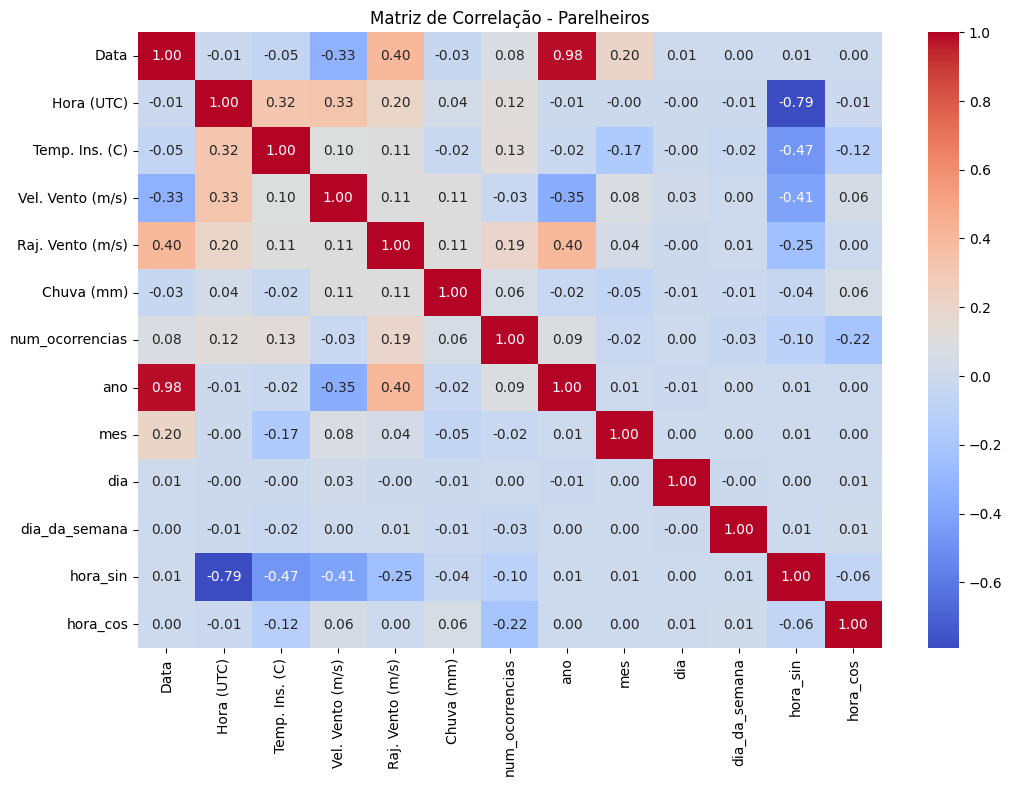

In [185]:
#Subsampling (Reduzindo a classe majoritária)
classe_zero = df[df['num_ocorrencias'] == 0]
classe_maior_que_zero = df[df['num_ocorrencias'] > 0]

# Reduzir a classe majoritária
classe_zero_amostrada = classe_zero.sample(len(classe_maior_que_zero), random_state=42)

# Concatenar as classes
df_balanceado = pd.concat([classe_zero_amostrada, classe_maior_que_zero])

# Embaralhar o DataFrame balanceado
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

correlation_matrix_df1 = df_balanceado.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_df1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação - Parelheiros')
plt.show()

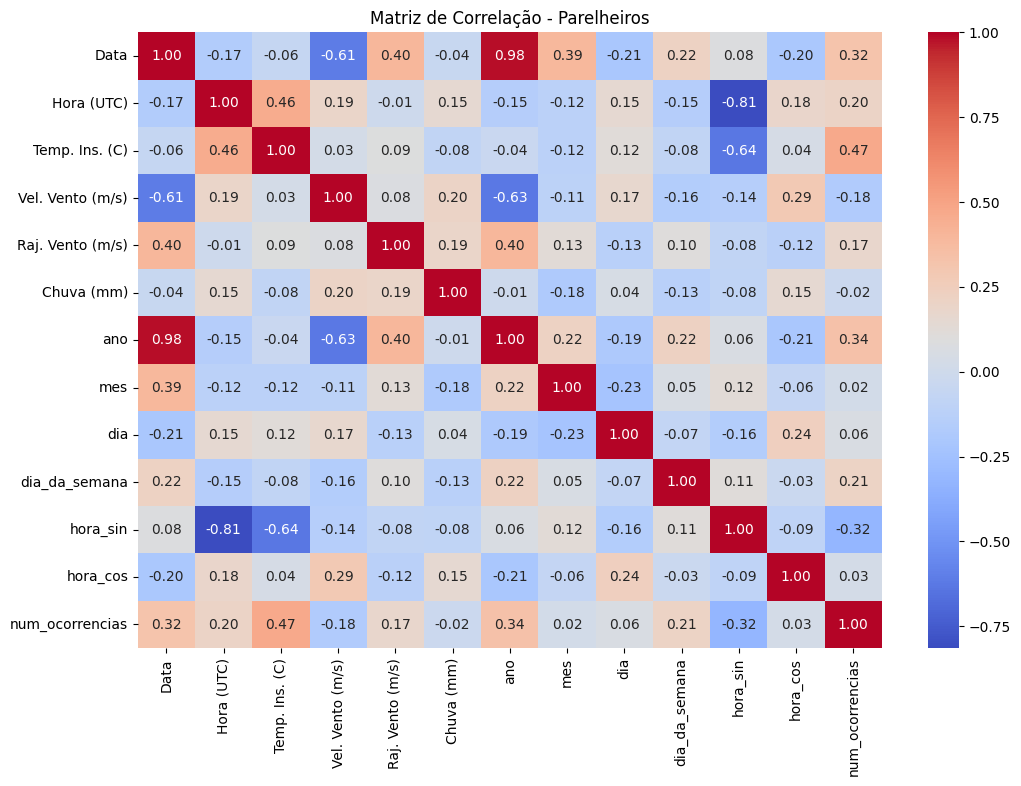

In [186]:
#Oversampling (Aumentando a classe minoritária)
# Separar as features e o alvo
X = df.drop('num_ocorrencias', axis=1)
y = df['num_ocorrencias']

# Criar o oversampler
ros = RandomOverSampler(random_state=42)

# Aplicar o oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Concatenar de volta as features e o alvo
df_balanceado1 = pd.DataFrame(X_resampled, columns=X.columns)
df_balanceado1['num_ocorrencias'] = y_resampled

correlation_matrix_df1 = df_balanceado1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_df1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação - Parelheiros')
plt.show()


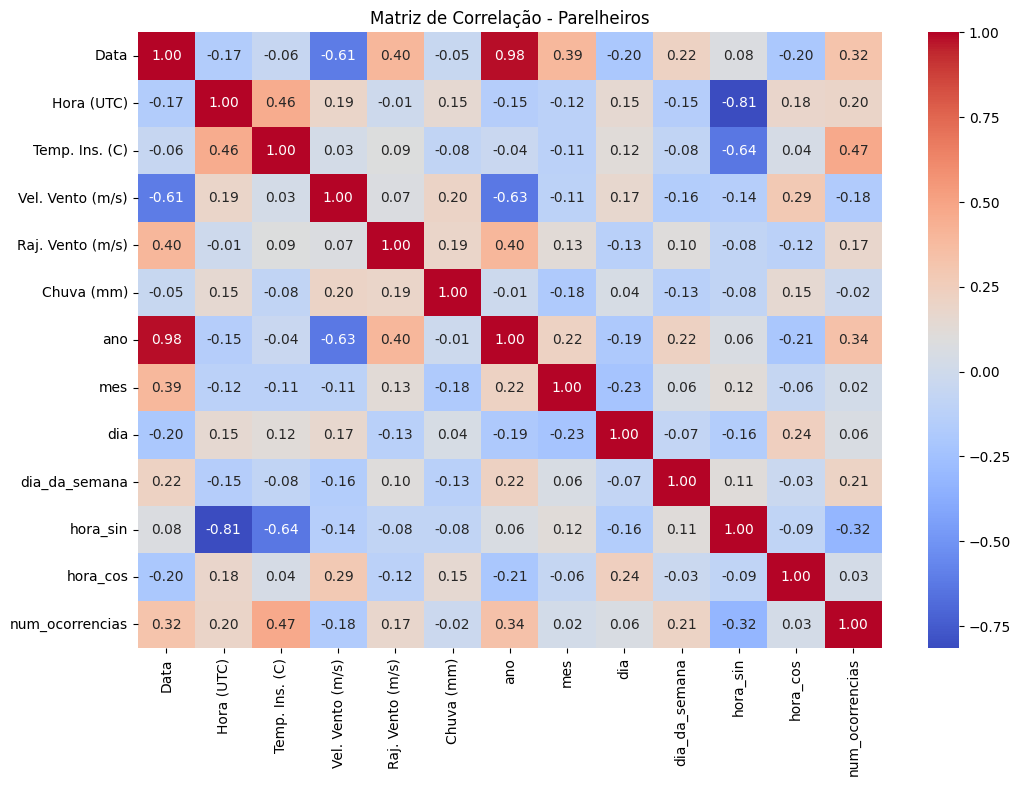

In [187]:
#combinação
# Separar as classes
classe_zero = df[df['num_ocorrencias'] == 0]
classe_maior_que_zero = df[df['num_ocorrencias'] > 0]

# Passo 1: Subsample a classe majoritária
# Manter o mesmo número de instâncias da classe minoritária
classe_zero_amostrada = classe_zero.sample(len(classe_maior_que_zero), random_state=42)

# Passo 2: Concatenar as classes
df_amostrado = pd.concat([classe_zero_amostrada, classe_maior_que_zero])

# Separar as features e o alvo
X = df_amostrado.drop('num_ocorrencias', axis=1)
y = df_amostrado['num_ocorrencias']

# Passo 3: Oversample a classe minoritária
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Concatenar de volta as features e o alvo
df_balanceado2 = pd.DataFrame(X_resampled, columns=X.columns)
df_balanceado2['num_ocorrencias'] = y_resampled

correlation_matrix_df1 = df_balanceado2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_df1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação - Parelheiros')
plt.show()


ANALISE

In [188]:
# Selecionar as colunas desejadas
colunas_desejadas = [
    'Temp. Ins. (C)', 
    'Vel. Vento (m/s)', 
    'Raj. Vento (m/s)', 
    'Chuva (mm)', 
    'num_ocorrencias'
]

# Filtrar o DataFrame original para manter apenas as colunas desejadas
df_filtrado = df[colunas_desejadas]

# Obter estatísticas descritivas para casos onde num_ocorrencias == 0
zero_ocorrencias = df_filtrado.loc[df_filtrado['num_ocorrencias'] == 0].describe()

# Obter estatísticas descritivas para casos onde num_ocorrencias > 0
ocorrencias = df_filtrado.loc[df_filtrado['num_ocorrencias'] > 0].describe()

# Exibir os resultados
print("Estatísticas para num_ocorrencias == 0:")
print(zero_ocorrencias)

print("\nEstatísticas para num_ocorrencias > 0:")
print(ocorrencias)



Estatísticas para num_ocorrencias == 0:
       Temp. Ins. (C)  Vel. Vento (m/s)  Raj. Vento (m/s)    Chuva (mm)  \
count    68045.000000      68045.000000      68045.000000  68045.000000   
mean        19.276505          4.480044          2.481667      0.100930   
std          4.406702          2.499614          1.833599      0.657122   
min          3.700000          0.100000          0.000000      0.000000   
25%         16.200000          2.400000          1.200000      0.000000   
50%         19.000000          4.200000          2.000000      0.000000   
75%         21.700000          6.300000          3.200000      0.000000   
max         37.900000         12.900000         12.900000     12.600000   

       num_ocorrencias  
count          68045.0  
mean               0.0  
std                0.0  
min                0.0  
25%                0.0  
50%                0.0  
75%                0.0  
max                0.0  

Estatísticas para num_ocorrencias > 0:
       Temp. Ins. (

In [189]:
ocorrencias

,Temp. Ins. (C),Vel. Vento (m/s),Raj. Vento (m/s),Chuva (mm),num_ocorrencias
count,17133.000000,17133.000000,17133.000000,17133.000000,17133.000000
mean,20.495208,4.808370,3.095021,0.348847,1.599603
std,4.844496,2.745425,3.448664,2.336640,1.362528
min,3.700000,0.100000,0.000000,0.000000,1.000000
25%,17.100000,2.700000,1.500000,0.000000,1.000000
50%,20.100000,4.400000,2.400000,0.000000,1.000000
75%,23.500000,6.600000,3.800000,0.000000,2.000000
max,37.200000,23.600000,100.000000,56.000000,46.000000


In [190]:
# Total de linhas
total_linhas = len(df)

# Linhas com num_ocorrencias igual a 0
linhas_zero_ocorrencias = len(df[df['num_ocorrencias'] == 0])

# Linhas com num_ocorrencias maior que 0
linhas_maior_que_zero_ocorrencias = len(df[df['num_ocorrencias'] > 0])

# Exibir os resultados
print(f"Quantidade total de linhas: {total_linhas}")
print(f"Quantidade de linhas com num_ocorrencias = 0: {linhas_zero_ocorrencias}")
print(f"Quantidade de linhas com num_ocorrencias = 1: {linhas_maior_que_zero_ocorrencias}")

# Total de linhas
total_linhas = len(df_balanceado)

# Linhas com num_ocorrencias igual a 0
linhas_zero_ocorrencias = len(df_balanceado[df_balanceado['num_ocorrencias'] == 0])

# Linhas com num_ocorrencias maior que 0
linhas_maior_que_zero_ocorrencias = len(df_balanceado[df_balanceado['num_ocorrencias'] > 0])

# Exibir os resultados
print('Subsampling')
print(f"Quantidade total de linhas: {total_linhas}")
print(f"Quantidade de linhas com num_ocorrencias = 0: {linhas_zero_ocorrencias}")
print(f"Quantidade de linhas com num_ocorrencias = 1: {linhas_maior_que_zero_ocorrencias}")

# Total de linhas
total_linhas = len(df_balanceado1)

# Linhas com num_ocorrencias igual a 0
linhas_zero_ocorrencias = len(df_balanceado1[df_balanceado1['num_ocorrencias'] == 0])

# Linhas com num_ocorrencias maior que 0
linhas_maior_que_zero_ocorrencias = len(df_balanceado1[df_balanceado1['num_ocorrencias'] > 0])

# Exibir os resultados
print('Oversampling')
print(f"Quantidade total de linhas: {total_linhas}")
print(f"Quantidade de linhas com num_ocorrencias = 0: {linhas_zero_ocorrencias}")
print(f"Quantidade de linhas com num_ocorrencias = 1: {linhas_maior_que_zero_ocorrencias}")

# Total de linhas
total_linhas = len(df_balanceado2)

# Linhas com num_ocorrencias igual a 0
linhas_zero_ocorrencias = len(df_balanceado2[df_balanceado2['num_ocorrencias'] == 0])

# Linhas com num_ocorrencias maior que 0
linhas_maior_que_zero_ocorrencias = len(df_balanceado2[df_balanceado2['num_ocorrencias'] > 0])

# Exibir os resultados
print('Subsampling e Oversampling')
print(f"Quantidade total de linhas: {total_linhas}")
print(f"Quantidade de linhas com num_ocorrencias = 0: {linhas_zero_ocorrencias}")
print(f"Quantidade de linhas com num_ocorrencias = 1: {linhas_maior_que_zero_ocorrencias}")


Quantidade total de linhas: 85178
Quantidade de linhas com num_ocorrencias = 0: 68045
Quantidade de linhas com num_ocorrencias = 1: 17133
Subsampling
Quantidade total de linhas: 34266
Quantidade de linhas com num_ocorrencias = 0: 17133
Quantidade de linhas com num_ocorrencias = 1: 17133
Oversampling
Quantidade total de linhas: 1701125
Quantidade de linhas com num_ocorrencias = 0: 68045
Quantidade de linhas com num_ocorrencias = 1: 1633080
Subsampling e Oversampling
Quantidade total de linhas: 428325
Quantidade de linhas com num_ocorrencias = 0: 17133
Quantidade de linhas com num_ocorrencias = 1: 411192


In [191]:
# Valores únicos de Chuva
chuva_counts = df['Chuva (mm)'].value_counts()
print("Valores únicos de Chuva (mm):")
print(chuva_counts)

# Valores únicos de Vel. Vento (m/s)
vento_counts = df['Vel. Vento (m/s)'].value_counts()
print("\nValores únicos de Vel. Vento (m/s):")
print(vento_counts)

# Valores únicos de Raj. Vento (m/s)
rajada_counts = df['Raj. Vento (m/s)'].value_counts()
print("\nValores únicos de Raj. Vento (m/s):")
print(rajada_counts)

Valores únicos de Chuva (mm):
Chuva (mm)
0.0     78052
0.2      2860
0.4       846
0.6       496
0.8       352
        ...  
8.6         2
24.8        2
34.4        2
36.2        2
15.6        2
Name: count, Length: 120, dtype: int64

Valores únicos de Vel. Vento (m/s):
Vel. Vento (m/s)
3.0     1424
4.0     1328
3.4     1322
2.0     1296
1.5     1292
        ... 
16.5       2
14.5       2
17.0       2
15.9       2
14.3       2
Name: count, Length: 166, dtype: int64

Valores únicos de Raj. Vento (m/s):
Raj. Vento (m/s)
1.2     2732
1.3     2714
1.4     2600
1.1     2576
1.0     2534
        ... 
13.8       2
19.4       2
17.2       2
19.5       2
17.9       2
Name: count, Length: 161, dtype: int64


In [192]:
# Filtrar apenas as linhas onde houve queda (num_ocorrencias > 0)
linhas_queda = df[df['num_ocorrencias'] == 0]

# Encontrar os valores mínimos nas colunas de interesse
min_vel_vento = linhas_queda['Vel. Vento (m/s)'].max()
min_raj_vento = linhas_queda['Raj. Vento (m/s)'].max()
min_chuva = linhas_queda['Chuva (mm)'].max()

# Filtrar as linhas com os valores mínimos
linhas_minimos = linhas_queda[
    (linhas_queda['Vel. Vento (m/s)'] == min_vel_vento) |
    (linhas_queda['Raj. Vento (m/s)'] == min_raj_vento) |
    (linhas_queda['Chuva (mm)'] == min_chuva)
]

# Selecionar apenas as colunas desejadas para exibir
resultados = linhas_minimos[['Vel. Vento (m/s)', 'Raj. Vento (m/s)', 'Chuva (mm)']]

# Exibir os resultados
print(resultados)


       Vel. Vento (m/s)  Raj. Vento (m/s)  Chuva (mm)
12998              12.9               4.9         0.0
12999              12.9               3.9         0.0
23007              12.9               3.6         0.0
25392               9.8               1.5        12.6
28312              12.9               4.8         0.0
39434               4.1              12.9         0.0
12998              12.9               4.9         0.0
19168              12.9               3.0         0.0
19215              12.9               1.2         2.8
23007              12.9               3.6         0.0
25392               9.8               1.5        12.6
28312              12.9               4.8         0.0
39434               4.1              12.9         0.0


In [193]:

# Criar um DataFrame para armazenar os resultados
resultados = pd.DataFrame({
    'Média': df[colunas].replace(0, pd.NA).mean(),
    'Mediana': df[colunas].replace(0, pd.NA).median(),
    'Moda': df[colunas].replace(0, pd.NA).mode().iloc[0],
    'Mínimo': df[colunas].min(),
    'Máximo': df[colunas].max()
})

# Exibir resultados
print(resultados)

                      Média Mediana  Moda  Mínimo  Máximo
Temp. Ins. (C)    19.521639    19.2  19.9     3.7    37.9
Vel. Vento (m/s)   4.546085     4.2   3.0     0.1    23.6
Raj. Vento (m/s)   2.605161     2.1   1.2     0.0   100.0
Chuva (mm)         1.802498     0.4   0.2     0.0    56.0
num_ocorrencias    1.599603     1.0   1.0     0.0    46.0


In [194]:

for coluna in colunas[:-1]:  # Excluir 'num_ocorrencias' da iteração
    valor_max = df[coluna].max()
    linhas_max = df[df[coluna] == valor_max]
    
    # Exibir apenas o valor de 'num_ocorrencias' correspondente
    for index, linha in linhas_max.iterrows():
        print(f"Valor máximo de {coluna}: {valor_max}, num_ocorrencias: {linha['num_ocorrencias']}")

Valor máximo de Temp. Ins. (C): 37.9, num_ocorrencias: 0.0
Valor máximo de Temp. Ins. (C): 37.9, num_ocorrencias: 0.0
Valor máximo de Vel. Vento (m/s): 23.6, num_ocorrencias: 10.0
Valor máximo de Vel. Vento (m/s): 23.6, num_ocorrencias: 4.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 5.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 6.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 2.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 4.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 3.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 2.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 2.0
Valor máximo de Raj. Vento (m/s): 100.0, num_ocorrencias: 2.0
Valor máximo de Chuva (mm): 56.0, num_ocorrencias: 4.0
Valor máximo de Chuva (mm): 56.0, num_ocorrencias: 2.0


In [195]:


# Criar um DataFrame vazio para armazenar os resultados
resultados = pd.DataFrame()

# Encontrar e exibir as linhas inteiras onde ocorrem os valores máximos
for coluna in colunas:
    valor_max = df[coluna].max()
    linhas_max = df[(df[coluna] == valor_max) & (df['num_ocorrencias'] != 0)]
    
    # Adicionar as linhas resultantes ao DataFrame de resultados
    resultados = pd.concat([resultados, linhas_max])

# Resetar o índice do DataFrame de resultados, se necessário
resultados.reset_index(drop=True, inplace=True)

# Exibir os resultados
print(resultados)

         Data  Hora (UTC)  Temp. Ins. (C)  Vel. Vento (m/s)  Raj. Vento (m/s)  \
0  2023-02-09          12            19.2              23.6              84.0   
1  2023-02-09          12            19.2              23.6              84.0   
2  2023-06-06          10            19.2              12.3             100.0   
3  2023-08-04           7            19.2              11.9             100.0   
4  2023-08-27          20            19.2              11.1             100.0   
5  2023-08-28           8            19.2              11.3             100.0   
6  2023-06-06          10            19.2              12.3             100.0   
7  2023-08-04           7            19.2              11.9             100.0   
8  2023-08-27          20            19.2              11.1             100.0   
9  2023-08-28           8            19.2              11.3             100.0   
10 2019-02-04           5            19.3              12.5               5.3   
11 2019-02-04           5   

In [196]:


# Encontrar os valores máximos para as colunas especificadas
maximos = df[colunas].max()

# Filtrar o DataFrame para linhas onde o número de ocorrências é igual a 0
linhas_zero_ocorrencias = df[df['num_ocorrencias'] == 0]

# Filtrar para ver se os máximos aparecem nas linhas onde num_ocorrencias é 0
resultado = linhas_zero_ocorrencias[
    (linhas_zero_ocorrencias['Temp. Ins. (C)'] == maximos['Temp. Ins. (C)']) |
    (linhas_zero_ocorrencias['Vel. Vento (m/s)'] == maximos['Vel. Vento (m/s)']) |
    (linhas_zero_ocorrencias['Raj. Vento (m/s)'] == maximos['Raj. Vento (m/s)']) |
    (linhas_zero_ocorrencias['Chuva (mm)'] == maximos['Chuva (mm)'])
]

# Exibir o resultado
print(resultado)


            Data  Hora (UTC)  Temp. Ins. (C)  Vel. Vento (m/s)  \
41772 2023-11-13          17            37.9               2.4   
41772 2023-11-13          17            37.9               2.4   

       Raj. Vento (m/s)  Chuva (mm)  num_ocorrencias   ano  mes  dia  \
41772              10.6         0.0              0.0  2023   11   13   
41772              10.6         0.0              0.0  2023   11   13   

       dia_da_semana  hora_sin  hora_cos  
41772              0 -0.965926 -0.258819  
41772              0 -0.965926 -0.258819  
